In [1]:
%pylab inline
import pandas as pd
from scipy.optimize import curve_fit
from scipy import asarray as ar
from scipy import math
import pylandau
import random

Populating the interactive namespace from numpy and matplotlib


# Importo il dataset

In [2]:
file = pd.read_csv(r'/home/gdeandrea/Scrivania/UNI/Econofisica/MyModels/Epstein/PRESE DATI/A-Valore Soglia/dati_rivolte_lunghe')
file.head()

,x,y,color,pen down?,x.1,y.1,color.1,pen down?.1,x.2,y.2,color.2,pen down?.2
0,0,1120,55,True,0,0,0,True,0,0,15,True
1,1,1098,55,True,1,17,0,True,1,5,15,True
2,2,1096,55,True,2,23,0,True,2,1,15,True
3,3,1097,55,True,3,23,0,True,3,0,15,True
4,4,1090,55,True,4,29,0,True,4,1,15,True


In [3]:
df = file['y.2']
y = df.to_numpy()
y = y[220:1200]
x = ar(range(len(y)))

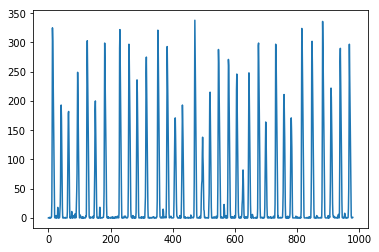

In [4]:
plt.plot(x,y)

# Definizioni Utili

## Fit Utils

In [5]:
def chiquadronorm(oss, fit, sigma, ddof, aiuto=False, norm=True):
    'funzione che calcola il chiquadrato di una distribuzione osservata rispetto a una\
    forma funzionale nota'
    
    #prende liste monodimensionali come argomenti
    scarti = []
    scartiquadri = []
    scartiquadridivisi = []
    
    for i in range(len(oss)):
        scarti.append(oss[i]-fit[i])
        scartiquadri.append(scarti[i]*scarti[i])
        scartiquadridivisi.append(scartiquadri[i]/(sigma[i]*sigma[i]))
        
        if (aiuto==True):
            print('scarti= ', scarti[i])
            print('scartiquadri= ', scartiquadri[i])
            print('scartiquadridivisi= ', scartiquadridivisi[i])
            
    chiquadro=sum(scartiquadridivisi)
    chiquadroreg=chiquadro/ddof
    
    if(norm==True):
        return (chiquadroreg)
    else:
        return (chiquadro)

def cost_chiquadronorm(oss, fit, sigma, ddof, aiuto=False, norm=True):
    'funzione che calcola il chiquadrato di una distribuzione osservata rispetto a una\
    forma funzionale nota'
    
    #prende liste monodimensionali come argomenti
    scarti = []
    scartiquadri = []
    scartiquadridivisi = []
    
    for i in range(len(oss)):
        scarti.append(oss[i]-fit)
        scartiquadri.append(scarti[i]*scarti[i])
        scartiquadridivisi.append(scartiquadri[i]/(sigma[i]*sigma[i]))
        
        if (aiuto==True):
            print('scarti= ', scarti[i])
            print('scartiquadri= ', scartiquadri[i])
            print('scartiquadridivisi= ', scartiquadridivisi[i])
            
    chiquadro=sum(scartiquadridivisi)
    chiquadroreg=chiquadro/ddof
    
    if(norm==True):
        return (chiquadroreg)
    else:
        return (chiquadro)

    
def media_pesata(x, sigma):
    numeratore = 0
    denominatore = 0
    for i in range(len(x)):
        numeratore += x[i]/(sigma[i]**2)
        denominatore += 1/(sigma[i]**2)
    return numeratore/denominatore

def costante(x,q):
    return q

def retta(x,m,q):
    return m*x +q

def gauss(x,a,x0,sigma,baseline):
    'Ritorna array gaussiano a partire da lista x secondo i parametri a,x0,sigma'
    return (baseline + a*exp(-(x-x0)**2/(2*sigma*sigma)))


def lore(x, a, x0, y0, baseline):
    'Ritorna array lorentziano a partire da lista x secondo i parametri a,x0,yo'
    return (baseline + a*(y0/(((x - x0)**2) + (y0**2))))

def fattoriale(x):
    temp_list = []

    for ics in x:
        f=1
        for i in range(1,ics+1):
            f*=i
        temp_list.append(f)
    return(temp_list)

def poisson(x, a, media, baseline):
    result = baseline + a*(media**x)*np.exp(-media)/fattoriale(x)
    return(result)

def landau(x, mpv, eta, A, baseline):
    x=double(x)
    'Ritorna array landauiano a partire da lista x secondo i parametri suoi'
    return (baseline + double(pylandau.landau(x, mpv=mpv, eta=eta, A=A)))

## Findings of previous step

In [6]:
soglia = 128.1241472701187
err_soglia = 12.6007119219633

## Selecting Spikes

In [7]:
def isola_spikes (y, datiesterni):
    '''
    Dati i dati sugli attivi, ritorna due dizionari: 
    {num_rivolta: [valori attivi]}
    {num_rivolta: [tick corrispondenti]}
    '''
    rivolte_diz = {}
    tick_rivolte_diz = {}
    temp_rivolta_list = []
    temp_tick_list = []
    rivolte_counter = 0
    cerarivolta = False
    
    for i in range(len(y)):
        
        ##aggiustato a 12 per non avere rivoltini
        if y[i] > 12:
            temp_rivolta_list.append(y[i])
            temp_tick_list.append(i)
            if cerarivolta == False:
                rivolte_counter += 1
                cerarivolta = True
        else:
            if cerarivolta == True:
                lunghezza=len(temp_rivolta_list)
                if rivolte_counter > 1:
                    if datiesterni == 1:
                        temp_rivolta_list.insert(0, y[i-lunghezza-1])
                        temp_tick_list.insert(0, i-lunghezza-1)
                    if datiesterni == 2:
                        temp_rivolta_list.insert(0, y[i-lunghezza-1])
                        temp_rivolta_list.insert(0, y[i-lunghezza-2])
                        temp_tick_list.insert(0, i-lunghezza-1)
                        temp_tick_list.insert(0, i-lunghezza-2)
                    if datiesterni == 3:
                        temp_rivolta_list.insert(0, y[i-lunghezza-1])
                        temp_rivolta_list.insert(0, y[i-lunghezza-2])
                        temp_rivolta_list.insert(0, y[i-lunghezza-3])
                        temp_tick_list.insert(0, i-lunghezza-1)
                        temp_tick_list.insert(0, i-lunghezza-2)
                        temp_tick_list.insert(0, i-lunghezza-3)
                else:
                    if datiesterni == 1:
                        temp_rivolta_list.insert(0, 0)
                        temp_tick_list.insert(0, i-lunghezza-1)
                    if datiesterni == 2:
                        temp_rivolta_list.insert(0, 0)
                        temp_rivolta_list.insert(0, 0)
                        temp_tick_list.insert(0, i-lunghezza-1)
                        temp_tick_list.insert(0, i-lunghezza-2)
                    if datiesterni == 3:
                        temp_rivolta_list.insert(0, 0)
                        temp_rivolta_list.insert(0, 0)
                        temp_rivolta_list.insert(0, 0)
                        temp_tick_list.insert(0, i-lunghezza-1)
                        temp_tick_list.insert(0, i-lunghezza-2)
                        temp_tick_list.insert(0, i-lunghezza-3)
                    
                if datiesterni == 1:
                        temp_rivolta_list.append(y[i])
                        temp_tick_list.append(i)
                if datiesterni == 2:
                        temp_rivolta_list.append(y[i])
                        temp_rivolta_list.append(y[i+1])
                        temp_tick_list.append(i)
                        temp_tick_list.append(i+1)
                if datiesterni == 3:
                        temp_rivolta_list.append(y[i])
                        temp_rivolta_list.append(y[i+1])
                        temp_rivolta_list.append(y[i+2])
                        temp_tick_list.append(i)
                        temp_tick_list.append(i+1)
                        temp_tick_list.append(i+2)
                
                rivolte_diz[str(rivolte_counter)+'_spike'] = temp_rivolta_list
                tick_rivolte_diz[str(rivolte_counter)+'_spike'] = temp_tick_list
                temp_rivolta_list = []
                temp_tick_list = []
                cerarivolta = False
                
    return rivolte_diz, tick_rivolte_diz

# Analisi

## Creo dizionario degli spikes

In [8]:
spikes_dict, spikes_tick_dict = isola_spikes(y, 3)

## Seleziono rivolte in base a valore di soglia trovato precedentemente

In [9]:
numero_sigma_soglia = 3
numero_sigma_baseline = 3
baseline = 2

In [10]:
## If soglia-errore_soglia < y + errore_y --> rivolta
rivolte_dict = {}
rivoltini_dict = {}
tick_rivolte_dict = {}
tick_rivoltini_dict = {}
rivolte_counter = 0
rivoltini_counter = 0
for spike in spikes_dict:
    y = spikes_dict[spike]
    x = spikes_tick_dict[spike]
    if np.max(y)+np.sqrt(np.max(y)) >= soglia-numero_sigma_soglia*err_soglia:
        rivolte_counter += 1
        rivolte_dict[str(rivolte_counter)+'_rivolta']=y
        tick_rivolte_dict[str(rivolte_counter)+'_rivolta']=x
    elif np.max(y)-numero_sigma_baseline*np.sqrt(np.max(y))>=baseline+numero_sigma_baseline*np.sqrt(baseline):
        rivoltini_counter += 1
        rivoltini_dict[str(rivoltini_counter)+'_rivolta']=y
        tick_rivoltini_dict[str(rivoltini_counter)+'_rivolta']=x

In [11]:
print(len(spikes_dict), len(rivolte_dict), len(rivoltini_dict))

38 34 1


In [12]:
rivoltini_dict

{'1_rivolta': [0, 0, 0, 23, 16, 4, 1, 2]}

## Calcolo Metriche: Durata, tempi d'attesa e ampiezza  
Tutte le metriche vengono ricavate dal calcolo dei parametri derivanti dalla procedura di fit:  
- Durata = 6sigma della rivolta considerata  
- Tempo attesa = (media[rivolta_i+1] - 3sigma[rivolta_i+1]) - (media[rivolta_i] + 3sigma[rivolta_i])  
- Ampiezza = parametro del fit  
  
Gli errori vengono calcolati dalla propagazione degli errori sui parametri del fit

In [13]:
## For loop che mi serve a trovare ampiezza, media e deviazione standard di ognuna delle rivolte,
###salvo i parametri del fit per ognuna delle rivolte
gauss_params_dict = {}
gauss_err_params_dict = {}
for rivolte in rivolte_dict:
    ## non considero 80_rivolta, è un errore della funzione 'isola_spike' che la isola come rivolta
    if rivolte != '80_rivolta':
        print(rivolte)
        temp_list = []
        temp_err_list = []
        y = rivolte_dict[rivolte]
        x = tick_rivolte_dict[rivolte]
        #print(x)
        #print(y)
        err_y = np.where(np.sqrt(y)==0,1,np.sqrt(y))
        gauss_params,gauss_cov = curve_fit(gauss,x,y,p0=[200,((x[-1]-x[0])/2)+x[0],4.,0.],sigma=err_y)
        temp_list.append(gauss_params[0])
        temp_list.append(gauss_params[1])
        temp_list.append(gauss_params[2])
        temp_list.append(gauss_params[3])
        temp_err_list.append(np.sqrt(np.abs(gauss_cov[0][0])))
        temp_err_list.append(np.sqrt(np.abs(gauss_cov[1][1])))
        temp_err_list.append(np.sqrt(np.abs(gauss_cov[2][2])))
        temp_err_list.append(np.sqrt(np.abs(gauss_cov[3][3])))
        gauss_params_dict[rivolte] = temp_list
        gauss_err_params_dict[rivolte] = temp_err_list

1_rivolta
2_rivolta
3_rivolta
4_rivolta
5_rivolta
6_rivolta
7_rivolta
8_rivolta
9_rivolta
10_rivolta
11_rivolta
12_rivolta
13_rivolta
14_rivolta
15_rivolta
16_rivolta
17_rivolta
18_rivolta
19_rivolta
20_rivolta
21_rivolta
22_rivolta
23_rivolta
24_rivolta
25_rivolta
26_rivolta
27_rivolta
28_rivolta
29_rivolta
30_rivolta
31_rivolta
32_rivolta
33_rivolta
34_rivolta


In [47]:
pd.DataFrame.from_dict(gauss_params_dict, orient='index')

<bound method NDFrame.describe of                      0           1         2         3
1_rivolta   320.657440   14.792786  1.745006 -1.777264
2_rivolta   199.878305   41.298969 -1.586316  0.044577
3_rivolta   207.272468   64.601636  1.564420 -1.331122
4_rivolta   236.060638   94.524033  1.836459 -0.515920
5_rivolta   297.850411  126.023046  1.703422 -0.755839
6_rivolta   202.437120  151.174439  1.663522 -0.891282
7_rivolta   274.592261  182.458213  1.893872 -1.340226
8_rivolta   321.436338  230.912984  1.665563 -1.462728
9_rivolta   293.185220  260.497248  1.787893 -0.767581
10_rivolta  246.074262  285.896363  1.690882 -1.843282
11_rivolta  272.429662  315.487187  1.824153 -0.849805
12_rivolta  315.179470  353.661984  1.779953 -0.931009
13_rivolta  284.592862  383.176543  1.786951 -1.159885
14_rivolta  185.258979  407.982732  1.871614 -0.736350
15_rivolta  208.315582  431.489630  1.598316 -1.247033
16_rivolta  323.490319  472.254005  1.689663 -1.207644
17_rivolta  125.239915  495.919

In [48]:
pd.DataFrame.from_dict(gauss_err_params_dict, orient='index')

,0,1,2,3
1_rivolta,41.242595,0.191714,0.133606,2.178037
2_rivolta,12.134490,0.079700,0.062639,0.630019
3_rivolta,17.142888,0.106728,0.085443,1.261203
4_rivolta,14.787838,0.093562,0.077802,0.936344
5_rivolta,38.125194,0.188746,0.136002,2.476906
6_rivolta,13.037126,0.087108,0.068776,0.842186
7_rivolta,27.603968,0.156252,0.120599,1.807339
8_rivolta,42.707268,0.191119,0.137661,2.289097
9_rivolta,30.185176,0.158216,0.112562,1.703961
10_rivolta,20.745784,0.115762,0.093807,1.527548


### Durata

In [14]:
## calcolo la durata delle singole rivolte come 6 per la sigma della rivolta (hp:gaussiane)
###e errori su singole durate propagando gli errori sulla sigma (6*err_assoluto sigma)
durate_list = [gauss_params_dict[rivolte][2]*6 for rivolte in rivolte_dict]
err_durate_list = [gauss_err_params_dict[rivolte][2]*6 for rivolte in rivolte_dict]
durate_list = np.abs(durate_list)
err_durate_list = np.abs(err_durate_list)

## calcolo media pesata e errore su media
media_pesata_durate = media_pesata(durate_list, err_durate_list)
err_media_pesata_durate = np.sqrt(np.sum((durate_list - media_pesata_durate)**2)/(len(durate_list)*(len(durate_list)-1)))

<ErrorbarContainer object of 3 artists>

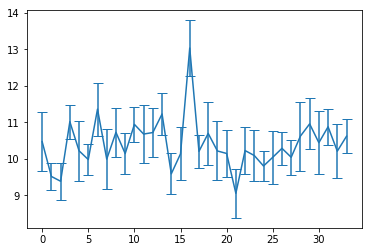

In [15]:
plt.errorbar(range(len(durate_list)), durate_list, yerr=err_durate_list,solid_capstyle='projecting',capsize=5)

In [16]:
print(media_pesata_durate, err_media_pesata_durate)

10.311830447971328 0.12035386293573513


### Tempi attesa

In [17]:
## calcolo liste dei tick di inizio e fine rivolte con relativi errori 
###trovati con propagazione degli errori dagli errori dei parametri del fit
###(start = media-3sigma --> err_start = sqrt(err_media**2 + (3err_sigma)**2)
start_tick_list = []
end_tick_list = []
err_start_tick_list = []
err_end_tick_list = []

for rivolte in gauss_params_dict:
    media = gauss_params_dict[rivolte][1]
    sigma = np.abs(gauss_params_dict[rivolte][2])
    err_media = gauss_err_params_dict[rivolte][1]
    err_sigma = gauss_err_params_dict[rivolte][2]
    start_tick_list.append(media - 3*sigma)
    end_tick_list.append(media + 3*sigma)
    err_start_tick_list.append(np.sqrt(err_media**2 + (3*err_sigma)**2))
    err_end_tick_list.append(np.sqrt(err_media**2 + (3*err_sigma)**2))

In [18]:
## Calcolo tempi di attesa dalle liste dei tick di inizio e fine rivolte e relativi errori
###calcolati con la propagazione dagli errori dei tick di inizio e fine rivolte
###(tempo_attesa = start[i+1]-end[i] --> err_tempo_attesa = np.sqrt(err_start[i+1]**2 + err_end[i]**2))
tempi_attesa_list = []
err_tempi_attesa_list = []
for i in range(len(end_tick_list)-1):
    tempi_attesa_list.append(start_tick_list[i+1] - end_tick_list[i])
    err_tempi_attesa_list.append(np.sqrt(err_start_tick_list[i+1]**2 + err_end_tick_list[i]**2))

In [19]:
## calcolo media pesata e errore su media
media_pesata_tempi_attesa = media_pesata(tempi_attesa_list, err_tempi_attesa_list)
err_media_pesata_tempi_attesa = np.sqrt(np.sum((tempi_attesa_list - media_pesata_tempi_attesa)**2)/(len(tempi_attesa_list)*(len(tempi_attesa_list)-1)))

<ErrorbarContainer object of 3 artists>

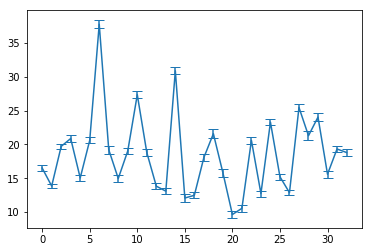

In [20]:
plt.errorbar(range(len(tempi_attesa_list)), tempi_attesa_list, yerr=err_tempi_attesa_list,solid_capstyle='projecting',capsize=5)

In [21]:
print(media_pesata_tempi_attesa, err_media_pesata_tempi_attesa)

17.850298917848043 1.0515878508062226


### Ampiezza

In [22]:
## Calcolo ampiezze per ogni rivolta e errore da propagazione errori del fit
ampiezze_list = [gauss_params_dict[rivolte][0] for rivolte in rivolte_dict]
err_ampiezze_list = [gauss_err_params_dict[rivolte][0] for rivolte in rivolte_dict]
ampiezze_list = np.abs(ampiezze_list)
err_ampiezze_list = np.abs(err_ampiezze_list)

## Calcolo media pesata e errore su media
media_pesata_ampiezze = media_pesata(ampiezze_list, err_ampiezze_list)
err_media_pesata_ampiezze = np.sqrt(np.sum((ampiezze_list - media_pesata_ampiezze)**2)/(len(ampiezze_list)*(len(ampiezze_list)-1)))

<ErrorbarContainer object of 3 artists>

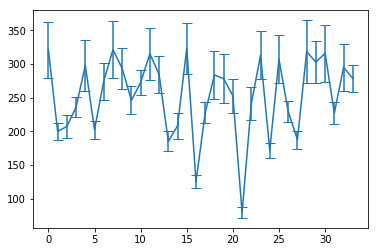

In [23]:
plt.errorbar(range(len(ampiezze_list)), ampiezze_list, yerr=err_ampiezze_list,solid_capstyle='projecting',capsize=5)

In [24]:
np.argmin(err_ampiezze_list)

21

In [25]:
print(media_pesata_ampiezze, err_media_pesata_ampiezze)

193.59670978171002 14.655492080565837


## Epstein - Tempi attesa  
Epstein afferma nel suo articolo che la distribuzione dei tempi di attesa per una rivolta segue un andamento a legge di potenza almeno nella coda destra della distribuzione, verifichiamolo

In [26]:
b = tempi_attesa_list

**Applico sturge's rule for binning**  
K = 1 + 3.322logN, K is num of bins, N is number of observations

In [27]:
N = len(b)
K = int(1 + 3.322*np.log(N))

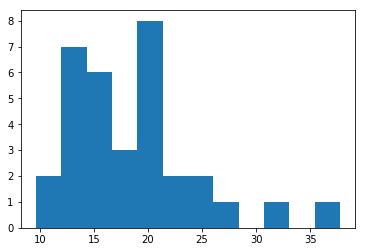

num_bin: 12  N: 33


In [28]:
counts, bins, bars = plt.hist(b, bins=K)
plt.show()
print('num_bin:', K, ' N:', N)

In [29]:
counts = counts[1:-4]
counts

array([7., 6., 3., 8., 2., 2., 1.])

In [30]:
bin_values = [(bins[i]+bins[i+1])/2 for i in range(len(bins[1:]))]
bin_values = bin_values[1:-4]
bin_values

[13.156298528845312,
 15.501076504155895,
 17.845854479466478,
 20.19063245477706,
 22.535410430087644,
 24.880188405398226,
 27.224966380708807]

In [31]:
err_counts = np.where(np.sqrt(counts)==0,1,np.sqrt(counts))/counts

In [32]:
counts

array([7., 6., 3., 8., 2., 2., 1.])

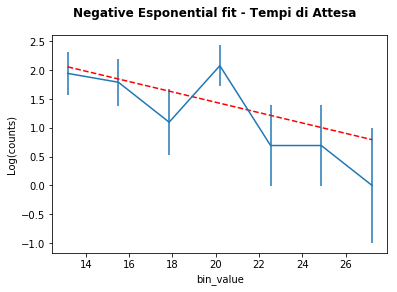

ReducedChiSquared: 1.152143102995739


In [33]:
popt, pcov = curve_fit(retta, bin_values, np.log(counts), sigma=err_counts)
plt.suptitle('Negative Esponential fit - Tempi di Attesa', fontweight='bold')
plt.xlabel('bin_value')
plt.ylabel('Log(counts)')
plt.errorbar(bin_values, np.log(counts), yerr=err_counts)
plt.plot(bin_values, [retta(bin_values[i], *popt) for i in range(len(bin_values))], 'r--')
plt.show()
tempi_attesa_chisq = chiquadronorm(np.log(counts), [retta(bin_values[i], *popt) for i in range(len(bin_values))], sigma=err_counts, ddof=len(counts)-len(popt))
print('ReducedChiSquared:', tempi_attesa_chisq)

**Come Epstein abbiamo verificato che l'andamento della distribuzione dei tempi di attesa è una negative esponential.**

## Test compatibilità soglie

In [34]:
## calcolo soglie come f(media-sigma) e errore come f(media-1.2*sigma)-f(media-0.8*sigma),
### prendo media e sigma dal dizionario che mi sono costruito
soglie = []
err_soglie = []
for i, rivolta in enumerate(rivolte_dict.keys()):
    
    media = gauss_params_dict[rivolta][1]
    sigma = gauss_params_dict[rivolta][2]
    sogliax = gauss(media-sigma, *gauss_params_dict[rivolta])
    errore = np.abs(gauss(media-1.2*sigma, *gauss_params_dict[rivolta])-gauss(media-0.8*sigma, *gauss_params_dict[rivolta]))
    
    soglie.append(sogliax)
    err_soglie.append(errore)

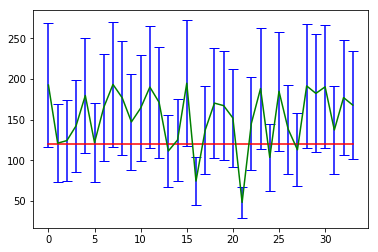

ReducedChiSquared: 0.9320298576062249


In [35]:
popt, pcov = curve_fit(costante, range(len(soglie)), soglie, sigma=err_soglie)
cost_red_chisq = cost_chiquadronorm(soglie, costante(range(len(soglie)),*popt), err_soglie, len(soglie)-len(popt), norm=True)
plt.plot(range(len(soglie)), [costante(range(len(soglie)),*popt) for k in range(len(soglie))], color='r')
plt.errorbar(range(len(soglie)), soglie, yerr=err_soglie,solid_capstyle='projecting',capsize=5,ecolor='blue',color='green')
plt.show()
print('ReducedChiSquared:', cost_red_chisq)

In [36]:
np.max(rivolte_dict['22_rivolta'])+np.sqrt(np.max(rivolte_dict['22_rivolta']))

91.05538513813741

In [37]:
soglia-3*err_soglia

90.3220115042288

In [38]:
baseline+numero_sigma_baseline*np.sqrt(baseline)

6.242640687119286

In [39]:
42-5*np.sqrt(42)

9.596296507960702

In [40]:
np.sqrt(pcov)

array([[8.51504977]])

In [41]:
popt

array([119.85078321])

In [42]:
media_pesata_soglie = media_pesata(soglie, err_soglie)
errore_media_soglia = np.sqrt(np.sum((soglie - media_pesata_soglie)**2)/(len(soglie)*(len(soglie)-1)))
print(media_pesata_soglie, errore_media_soglia)

119.85078310462809 8.44068794924578


**Ho, come nel caso precedente dove consideravo meno rivolte, valori di soglia compatibili con un valore costante**  
inoltre il valore di soglia trovato è compatibile con il valore di soglia trovato precedentemente